# Predicting fish weight from other highly correlated covariates

#### Thomas N. Larsen and Sindre B. Remman

## Report outline
- Introduction: 
    - Presenting the dataset.
    - Multicollinearity and heteroscedasticity.
    - Splitting the data into training, validation and test data.
- Analysis:
    - Heteroscedasticity.
    - Ordinary Least Squares.
    - Rigde regression.
    - Lasso regression.
    - Sparse Group Lasso.
- Results:
    - Applying the methods to the test data.
    - Comparing the models' coefficients.
    - Discussing which method is best for the dataset.

In [1]:
# Essential tools
import pandas
import numpy as np

# Regression models and utils
import sklearn
from sklearn import preprocessing
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate

# Sparse Group lasso from pypi.org
from group_lasso import GroupLasso

# Plotting tools
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
import plotly
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Normality testing
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Introduction

### The dataset - Fish Market
Our chosen dataset contains 159 samples from 7 different species of fish [2]. With this dataset, our aim is to create a predictive model using multiple linear regression to estimate the weight of the fish. 

| Covariate | Description | Scale |
|----------|-------------------------|---------------|
| Species: | Name of the fish        | [categorical] |
| Weight:  | Weight of fish in grams | [g]           |
| Length1: | Vertical length         | [cm]          |
| Length2: | Diagonal length         | [cm]          |
| Length3: | Cross length            | [cm]          |
| Height:  | Height                  | [cm]          |
| Width:   | Diagonal width          | [cm]          |

Below, the correlation matrix is shown for continuous variables. Looking at the correlation matrix, it is clear that the covariates suffer from multicollinearity. Notice that the covariates regarding the lengths of the fish are nearly perfectly correlated. We can also see from the pairplot below that we have some cases of heteroscedasticity in the data. 

  Species  Weight  Length1  Length2  Length3   Height   Width
0   Bream   242.0     23.2     25.4     30.0  11.5200  4.0200
1   Bream   290.0     24.0     26.3     31.2  12.4800  4.3056
2   Bream   340.0     23.9     26.5     31.1  12.3778  4.6961
3   Bream   363.0     26.3     29.0     33.5  12.7300  4.4555
4   Bream   430.0     26.5     29.0     34.0  12.4440  5.1340


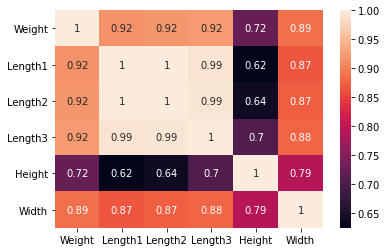

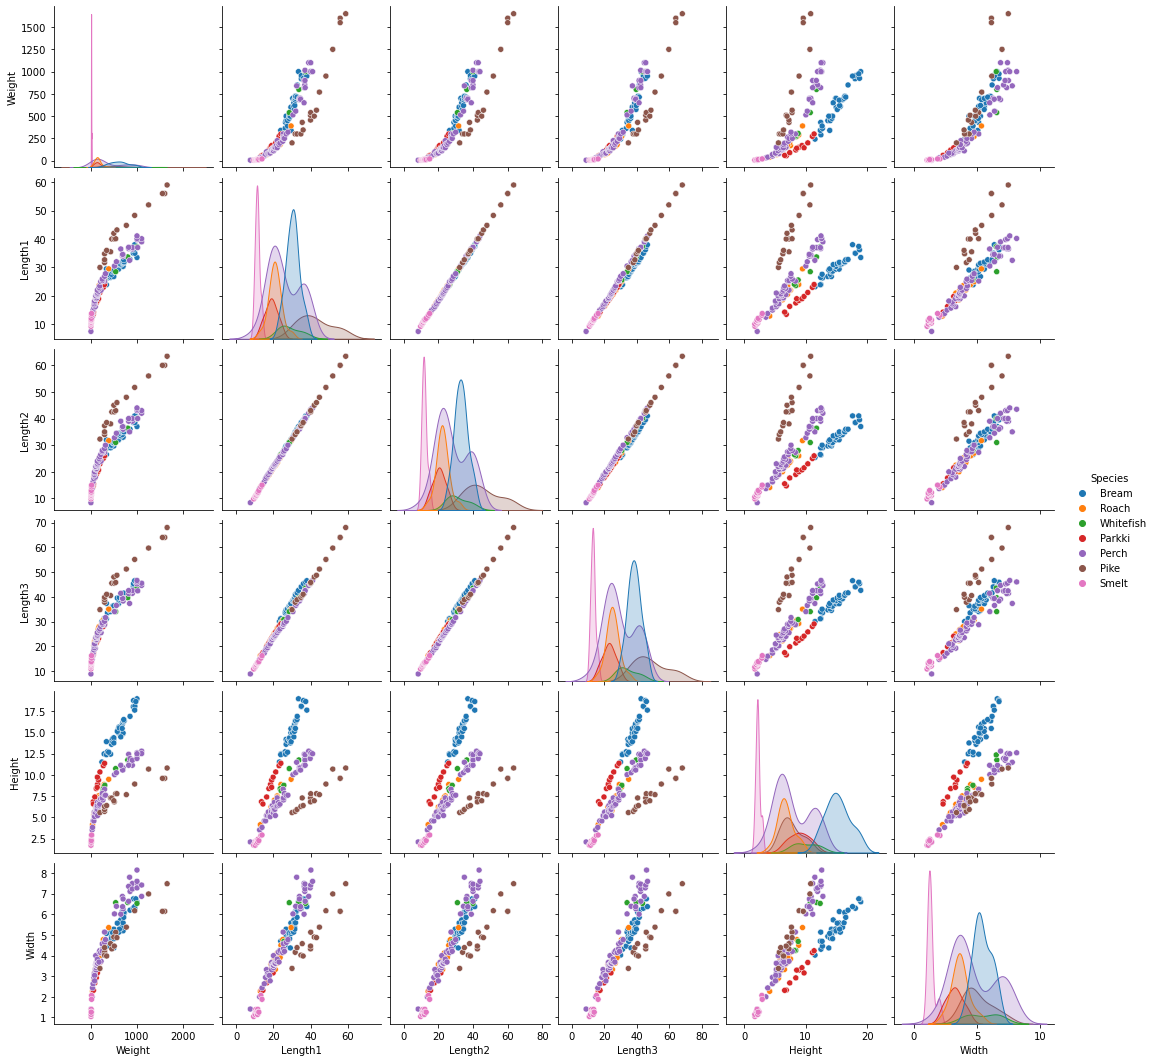

In [2]:
# Load Fish Market dataset
data = pandas.read_csv("Fish.csv")

print(data.head())


# Removing outliers (there is one)
data = data[data.Weight != 0]

# Print correlation matrix and pair plot
corrMatrix = data.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

sn.pairplot(data, hue="Species")
plt.show()

## Data preprocessing
To prepare the data, we separate the covariates, $X$, from the responses, $y$, from the full dataset. To accommodate the categorical variable $\textit{Species}$, we use one-hot encoding. This covariate is therefore split into 7 columns of boolean values. Then, the data is split into training and test sets. The normalization parameters are fit to the training data only, such that we avoid peeking at the test data in normalization.

The one-hot encoded $\textit{Species}$ are included in the new correlation matrices below. Naturally, the species seem to group the data into narrow ranges of the other physical attributes, i.e., $\textit{Species}$ may be an important predictor for the weight.

   Species_Bream  Species_Parkki  Species_Perch  Species_Pike  Species_Roach  \
0              1               0              0             0              0   
1              1               0              0             0              0   
2              1               0              0             0              0   
3              1               0              0             0              0   
4              1               0              0             0              0   

   Species_Smelt  Species_Whitefish  Weight  Length1  Length2  Length3  \
0              0                  0   242.0     23.2     25.4     30.0   
1              0                  0   290.0     24.0     26.3     31.2   
2              0                  0   340.0     23.9     26.5     31.1   
3              0                  0   363.0     26.3     29.0     33.5   
4              0                  0   430.0     26.5     29.0     34.0   

    Height   Width  
0  11.5200  4.0200  
1  12.4800  4.3056  
2  12.3778 

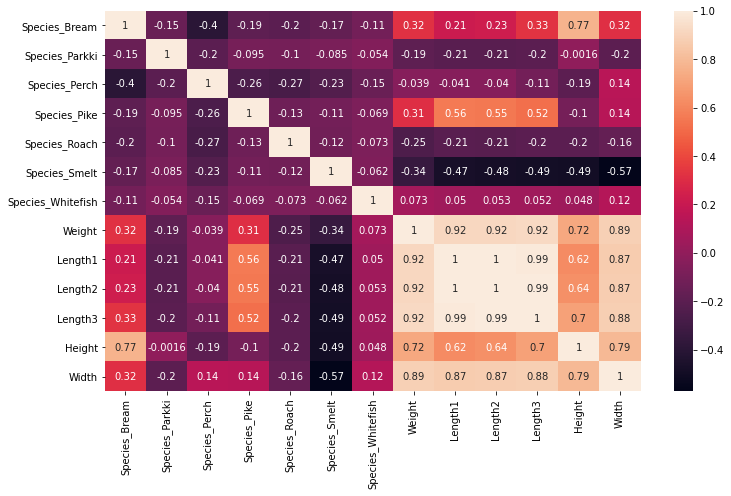

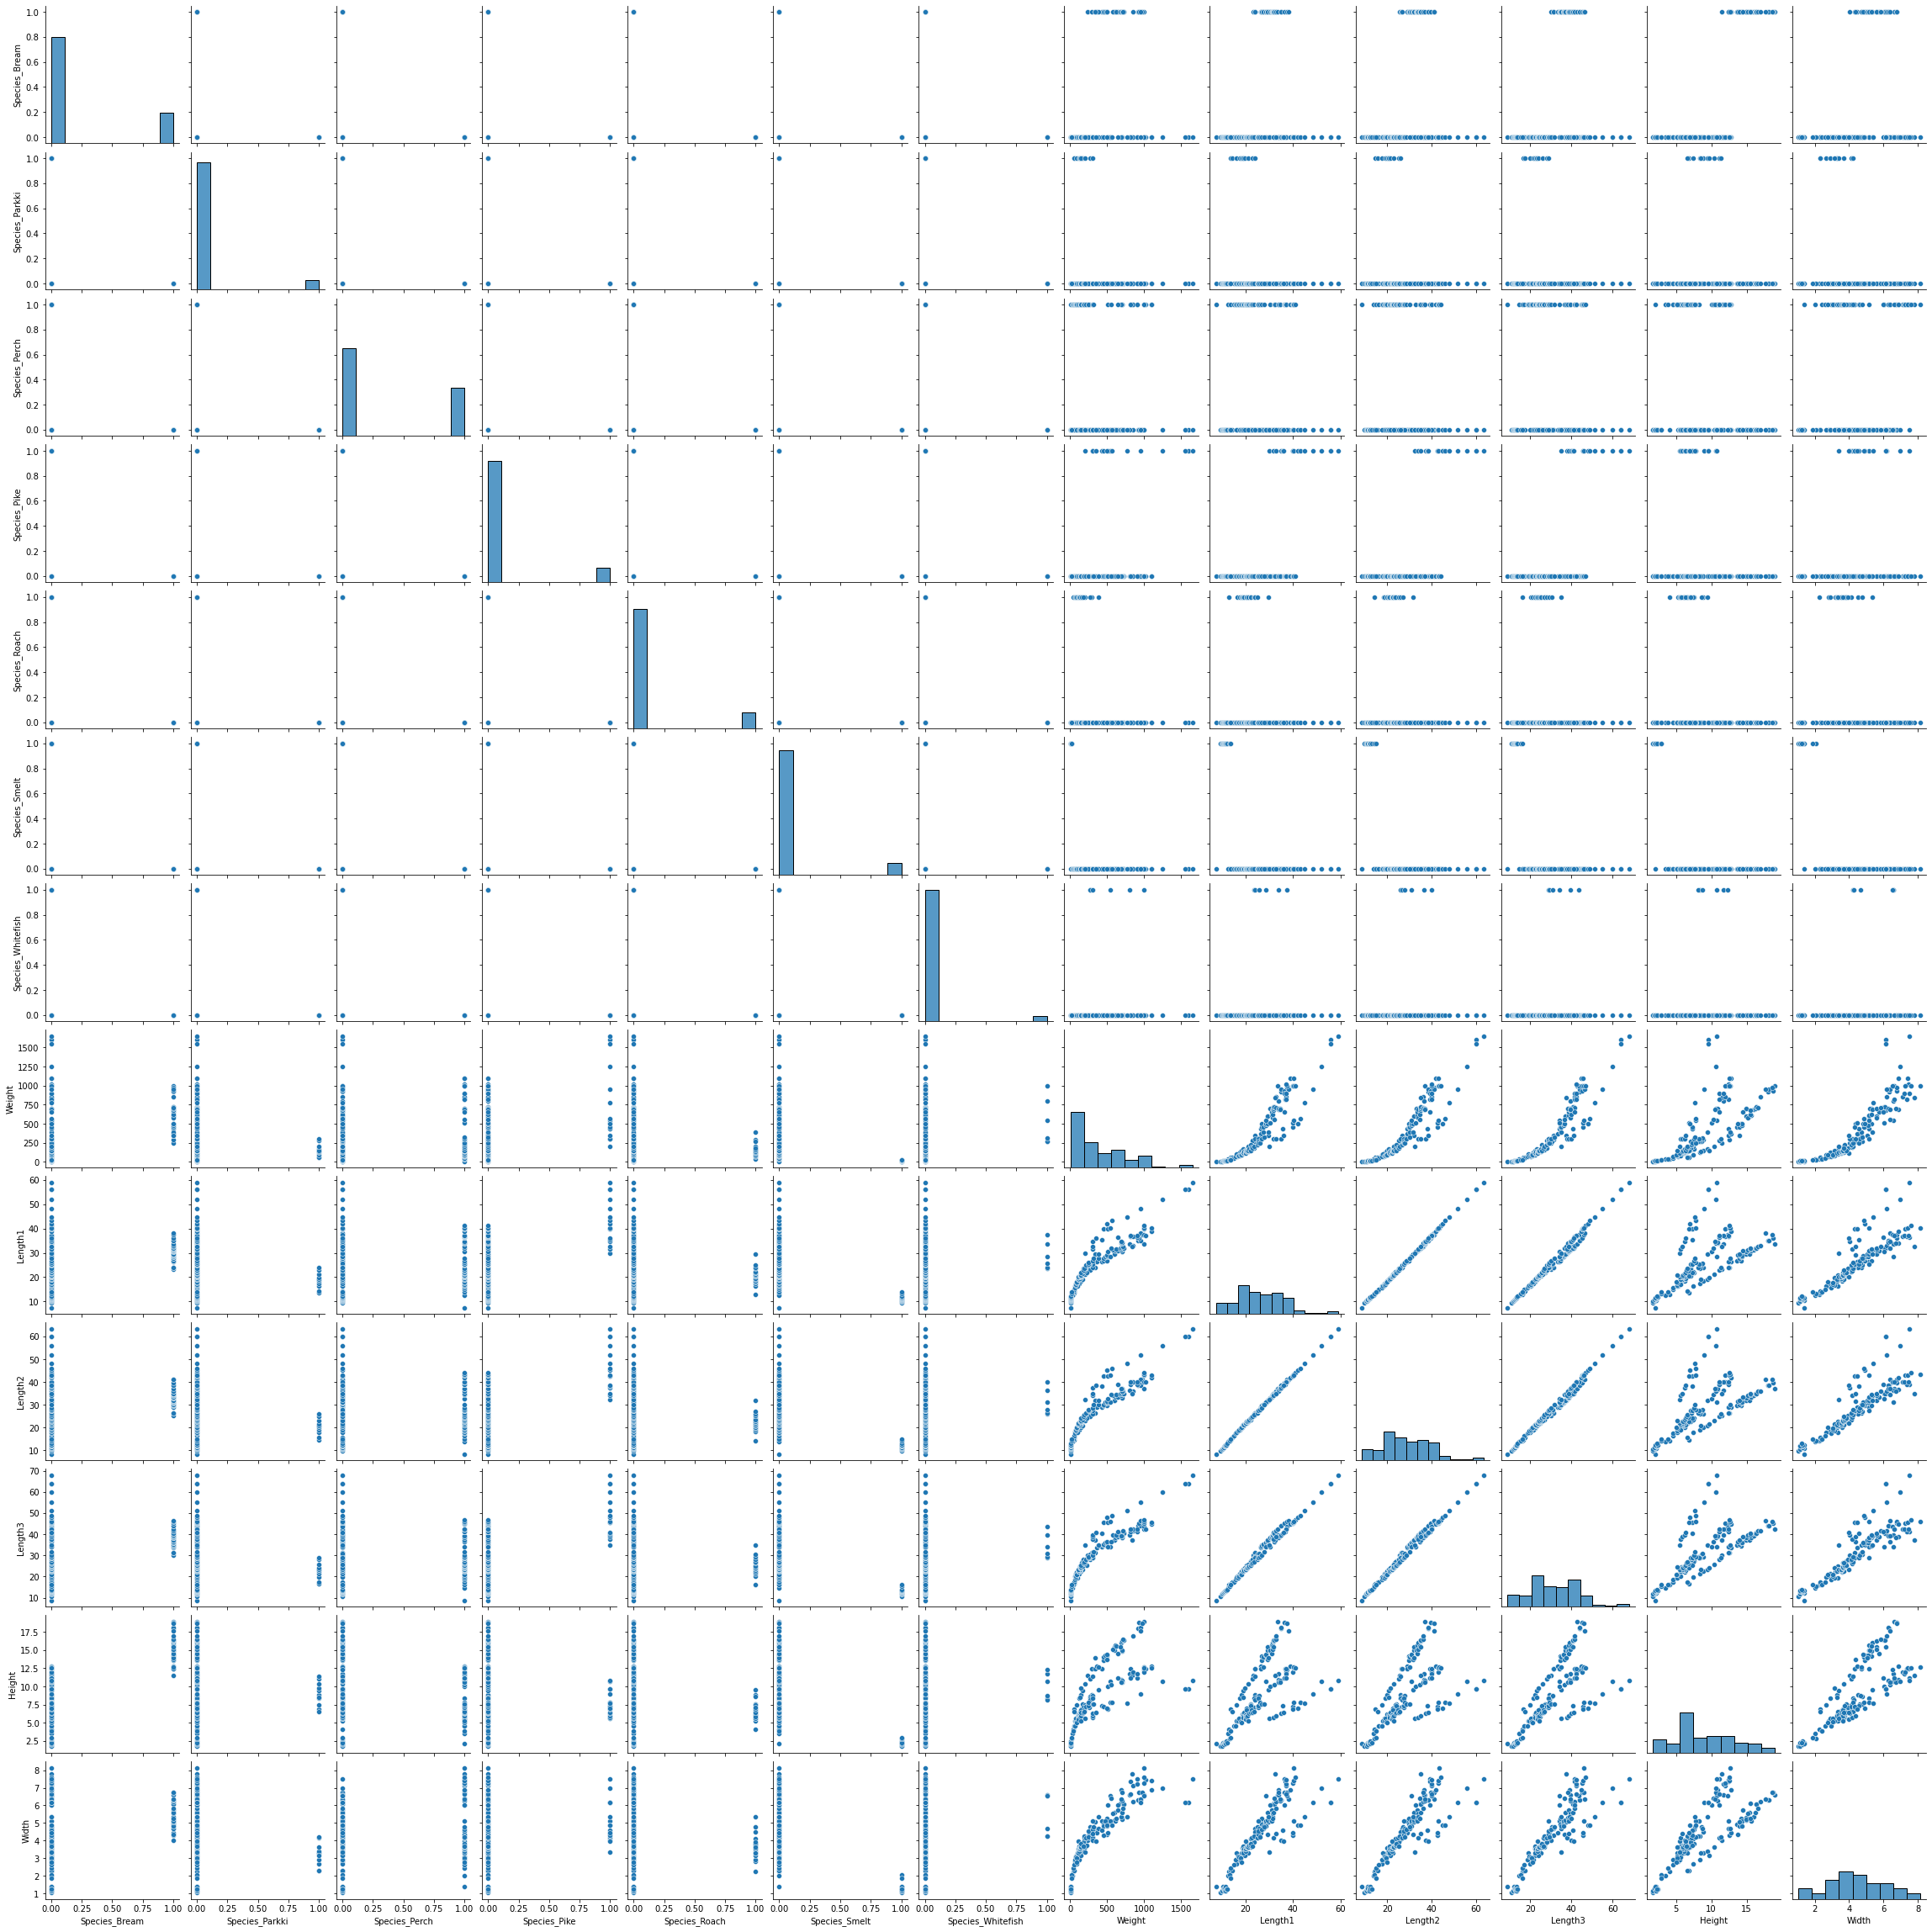

In [26]:
# One-Hot encoding the species covariate
species = pandas.get_dummies(data.Species, prefix="Species")
X = data.copy().drop(["Species"], axis=1)
X = pandas.concat([species, X], axis=1)
print(X.head())

# Plot correlation with one-hot encoding
corrMatrix = X.corr()
fig,ax = plt.subplots(figsize=(12,7))
sn.heatmap(corrMatrix, annot=True, ax=ax)
plt.show()

sn.pairplot(X)
plt.show()

# Separating data into response values (Y) and inputs (X)
y = data["Weight"]
X = X.drop(["Weight"], axis=1)

# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)  # Unleash the random when all code is finished

# Normalize columns in X, fitting the normalization parameters to the training data only
min_max_scaler = preprocessing.MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_train = pandas.DataFrame(X_train_scaled, columns=X.columns)

# Use normalization parameters found for the training data to transform the test data.
X_test_scaled = min_max_scaler.transform(X_test)
X_test = pandas.DataFrame(X_test_scaled, columns=X.columns)

# Transform responses y with logarithm to avoid heteroscedasticity
# y = ( y - min(y) ) / (max(y) - min(y))

In [4]:
print(X_train.head())

   Species_Bream  Species_Parkki  Species_Perch  Species_Pike  Species_Roach  \
0            1.0             0.0            0.0           0.0            0.0   
1            0.0             0.0            1.0           0.0            0.0   
2            0.0             0.0            1.0           0.0            0.0   
3            0.0             0.0            1.0           0.0            0.0   
4            1.0             0.0            0.0           0.0            0.0   

   Species_Smelt  Species_Whitefish   Length1   Length2   Length3    Height  \
0            0.0                0.0  0.489320  0.501818  0.552365  0.858375   
1            0.0                0.0  0.514563  0.510909  0.510135  0.531245   
2            0.0                0.0  0.485437  0.483636  0.481419  0.566500   
3            0.0                0.0  0.242718  0.247273  0.248311  0.254321   
4            0.0                0.0  0.454369  0.456364  0.503378  0.807065   

      Width  
0  0.672486  
1  0.817261  
2 

# Analysis
In this chapter we apply Ordinary Least Squares, Ridge regression, Lasso regression and Group Lasso regression on our data. The aim is to find how the different methods handle the multicollinearity in the data. Each method will be briefly introduced and their results are compared in the next chapter. Before applying these methods, we first investigate how to handle the heteroscedasticity in our data.

---

## Presence of heteroscedasticity

Heteroscedasticity may impact the regression models' predictive performance. 
One way to dampen heteroscedasticity is to transform the weight response into log-weights. 
To evaluate the effect, we fit OLS models to normal weights and log-weights and look at the Q-Q plots of the residuals.

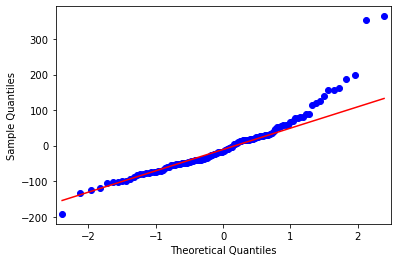

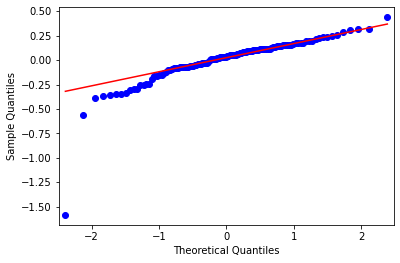

In [5]:
# Fit OLS
ls_fit = lm.LinearRegression(fit_intercept=False).fit(X_train, y_train)
pred = ls_fit.predict(X_train)
res  = (y_train - pred)

fig = sm.qqplot(res, line='q')
plt.show()


# Fit OLS with log-transformed response
ls_fit = lm.LinearRegression(fit_intercept=False).fit(X_train, np.log(y_train))
pred = ls_fit.predict(X_train)
res  = (np.log(y_train) - pred)

fig = sm.qqplot(res, line='q')
plt.show()

Comparing the two residual Q-Q plots, it may seem that the log-transformed responses give more normally distributed residuals. To verify this, we can apply some additional normality tests using the R-inspired statsmodels.formula.api. [3]

In [6]:
_df = X_train.copy()
_df["Weight"] = y_train

_df_log = X_train.copy()
_df_log["Weight"] = np.log(y_train)

f ='Weight~Length1+Length2+Length3+Height+Width+Species_Bream+Species_Parkki+Species_Perch+Species_Pike+Species_Roach+Species_Smelt'
model = smf.ols(f,data=_df)
result = model.fit()
print(result.summary())


log_model = smf.ols(f,data=_df_log)
log_result = log_model.fit()
print(log_result.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9929
Date:                Mon, 01 Mar 2021   Prob (F-statistic):              0.461
Time:                        13:16:47   Log-Likelihood:                -605.76
No. Observations:                  87   AIC:                             1236.
Df Residuals:                      75   BIC:                             1265.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        415.1749    337.178      1.

The automated normality tests above gives the following results:

Without log-weight transformation:
| Method | Value | Method | Value |
| --- | --- | --- | --- |
Omnibus:                      |  7.651  | Durbin-Watson:             |      0.634
Prob(Omnibus):                |  0.022  | Jarque-Bera (JB):          |      6.008
Skew:                         |  0.533  | **Prob(JB):**              |     **0.0496**
Kurtosis:                     |  2.278  | Cond. No.                  |       595.


With log-weight transformation:
| Method | Value | Method | Value |
| --- | --- | --- | --- |
Omnibus:                      | 12.231  | Durbin-Watson:             |      0.717
Prob(Omnibus):                |  0.002  | Jarque-Bera (JB):          |     14.030
Skew:                         | -0.736  | **Prob(JB):**              |   **0.000898**
Kurtosis:                     |  4.305  | Cond. No.                  |       595.


In these summaries, the **Prob(JB)** values correspond to p-values. For the null hypothesis that the data is homoscedastic, these should be higher than the significance level, typically chosen to be around 0.05. It is obvious that the log-transform significantly reduces the p-value. From this analysis, it seems that log-transforming the response is not helpful. Nevertheless, we also test the cross-validation performance for Ordinary Least Squares with and without the log-transform to investigate the effect on the model's predictive power.

## Least Squares
Ordinary least squares (OLS) will be used as a benchmark against the regularized methods. In short, OLS constructs an estimator $\hat{\beta}$ by:

$\hat{y} = X^T\hat{\beta}$, where $\hat{\beta}$ is chosen such that $\min_\hat{\beta} ||X^T\hat{\beta} - y||_2^2$.

To find $\hat{\beta}$, we use the implementation in sklearn.linear_model.LinearRegression(), and apply 10-fold cross-validation using sklearn.model_selection.cross_validate() to evaluate the model. 

As mentioned above, we also run cross-validation with and without the log-transformed response variable to determine whether this transformation is benefitial.

In [7]:
method = lm.LinearRegression(fit_intercept=False)

log_y_train = np.log(y_train.copy())

scores = cross_validate(method, X_train, y_train, cv=10, scoring="r2")
print("Cross-Validation R2-score is {:0.3f} +/- {:0.3f}".format(scores["test_score"].mean(), scores["test_score"].std()))

scores = cross_validate(method, X_train, log_y_train, cv=10, scoring="r2")
print("Cross-Validation R2-score for log-transform is {:0.3f} +/- {:0.3f}".format(scores["test_score"].mean(), scores["test_score"].std()))

ols_cv_mean = scores["test_score"].mean()
ols_cv_std = scores["test_score"].std()


LS_model = method.fit(X_train,np.log(y_train))

Cross-Validation R2-score is 0.908 +/- 0.048
Cross-Validation R2-score for log-transform is 0.954 +/- 0.034


As we can see from these results, the cross-validation results are significantly better when the response is log-transformed. Therefore, we continue to use this log-transformed response throughout the rest of the report.

In [8]:
y_train = np.log(y_train)
y_test  = np.log(y_test)

### Functions for cross-validating a range of regularizer values.
In the subsequent regularized methods, some hyperparameter tuning is required to determine the optimal level of regularization. Therefore, we need to create some functions that cross-validate a range of hyperparameters.



In [20]:
# Cross-Validation for regularization selection


# Create custom color map to avoid cycling through standard colors
rcParams['axes.prop_cycle'] = cycler(color=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'navy', 'maroon'])

def reg_select(method_func, X, y, alphas=[0.1,1,10]):
    '''
    A cross-validation function that finds the mean and standard deviation of R2-scores for a
    range of the regularization hyperparameter. This function also returns the coefficients of the model.
    
    params:
        method_func: sklearn regression method.
        X:           input data [pandas.DataFrame]
        y:           target values [pandas.Series]
        alphas:      list of hyperparameter values to traverse [list]

    returns: 
        score_means: mean CV score for each alpha [numpy.ndarray]
        score_stds:  standard deviation of CV score for each alpha [numpy.ndarray]
        score_coef:  model coefficients [numpy.ndarray]
    '''    
    # Initialize containers
    score_means = []
    score_stds = []
    score_coef = []
    
    # Do cross-validation for each value for alpha.
    for alpha in alphas:
        # Progress bar
        print("\rProcessing alpha {:0.2f} of {:0.2f}".format(alpha, alphas[-1]), end="", flush=True)
        
        # Update method's regularizer value
        method = method_func(alpha=alpha, max_iter=20000000, tol=0.0001)

        # more k-fold CV:
        scores = cross_validate(method, X, y, cv=10, return_estimator=True, scoring='r2')
        
        # Store scores
        score_means.append(scores["test_score"].mean())
        score_stds.append(scores["test_score"].std())
        score_coef.append(method.fit(X, y).coef_)
       
    score_means = np.array(score_means)
    score_stds  = np.array(score_stds)
    score_coef  = np.array(score_coef)
    
    print(" ")  # Newline after progress bar has finished
    return score_means, score_stds, score_coef


def plot_regularizer(range_reg, mean_scores, std_scores, coeffs, column_name, method="Ridge"):
    '''
    To illustrate the best choice for the regularizer, we define a function to plot the cross-validated scores vs. the regularization hyperparameter, and to plot the model coefficients vs the regularization hyperparameter.
    
    params:
        range_reg:       regularizer hyperparameters that have been tested in reg_select [numpy.ndarray]
        mean_scores:     mean scores from reg_select [numpy.ndarray]          
        std_scores:      standard deviation of scores from reg_select [numpy.ndarray]           
        coeffs:          the coefficients of the models that have been tested in reg_select [numpy.ndarray]
        column_name:     names of the covariates [list] 
        method:          Regularizer name [string]
        
    returns:
        None
    '''
    
    plt.figure(figsize=(20,10))
    plt.plot(range_reg, mean_scores, 'r+')
    best_alpha = range_reg[np.argmax(mean_scores)]
    plt.axvline(best_alpha)
    plt.fill_between(range_reg, (mean_scores - std_scores), (mean_scores + std_scores), alpha=0.1)
    plt.xscale('log')
    plt.xlabel(r"$\log (\alpha)$")
    plt.ylabel("R2 score")
    plt.title(method+" scores as a function of the regularization hyperparameter", fontsize=20);
    
    plt.figure(figsize=(20,10))
    plt.plot(range_reg, coeffs)
    plt.title(method+" coefficients as a function of the regularization hyperparameter", fontsize=20);
    plt.xscale('log')
    plt.xlabel(r"$\log (\alpha)$")
    plt.ylabel("Weights")
    plt.legend(column_name)

## Ridge regression

Regularizes the models by limiting the coefficients' size according to: 
$\min_\beta ||X^T\beta - y||_2^2 + \alpha ||\beta||_2^2$

We first find the mean and standard deviations of the R2 scores according to the function defined above. We then select the regularization hyperparameter that gave the best mean score during the cross-validation.

The first plot shows the R2 scores as a function of the regularization hyperparameter, where the blue vertical line shows the $\alpha$ that gave the best mean R2-score. The second plot shows how the coefficients change with increasing $\alpha$.

In the coefficient plot, we can see that the coefficient for the almost perfectly correlated variables length1 and length2 are poorly defined. Length2 has a large positive value and the coefficient of length1 cancels this out by having a correspondingly large negative value. As the regularization hyperparameter is increased, these coefficients become smaller, and the problem of large coefficients is alleviated as described in [1, p. 63].

Processing alpha 10000.00 of 10000.00 
Best alpha is  0.6579332246575682
Cross-Validation R2-score is 0.960 +/- 0.030


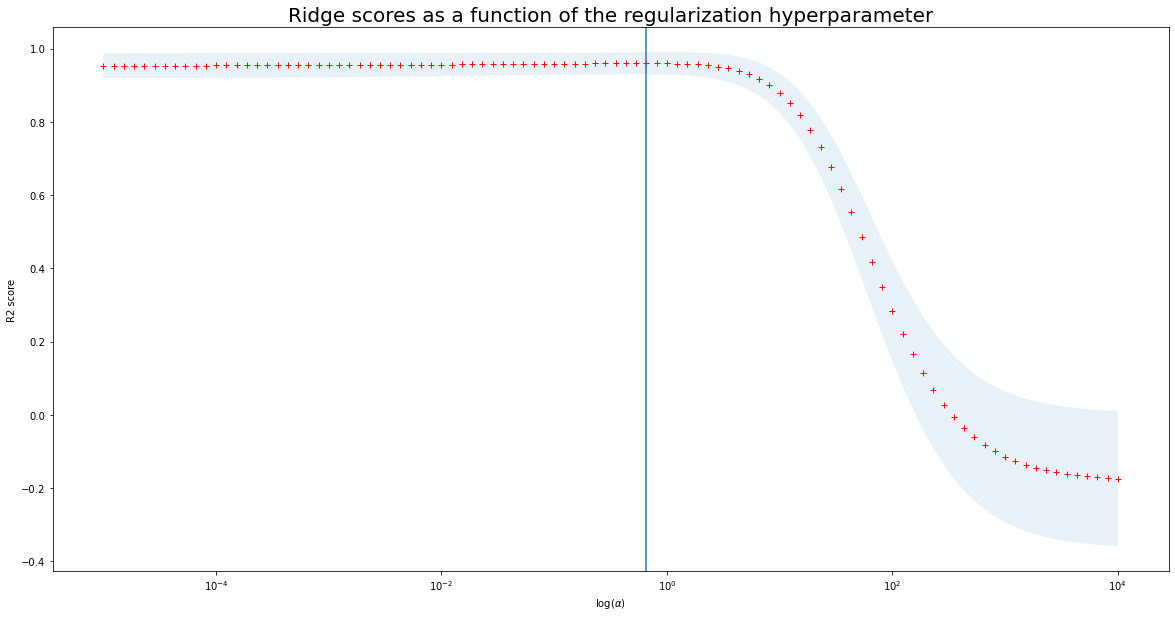

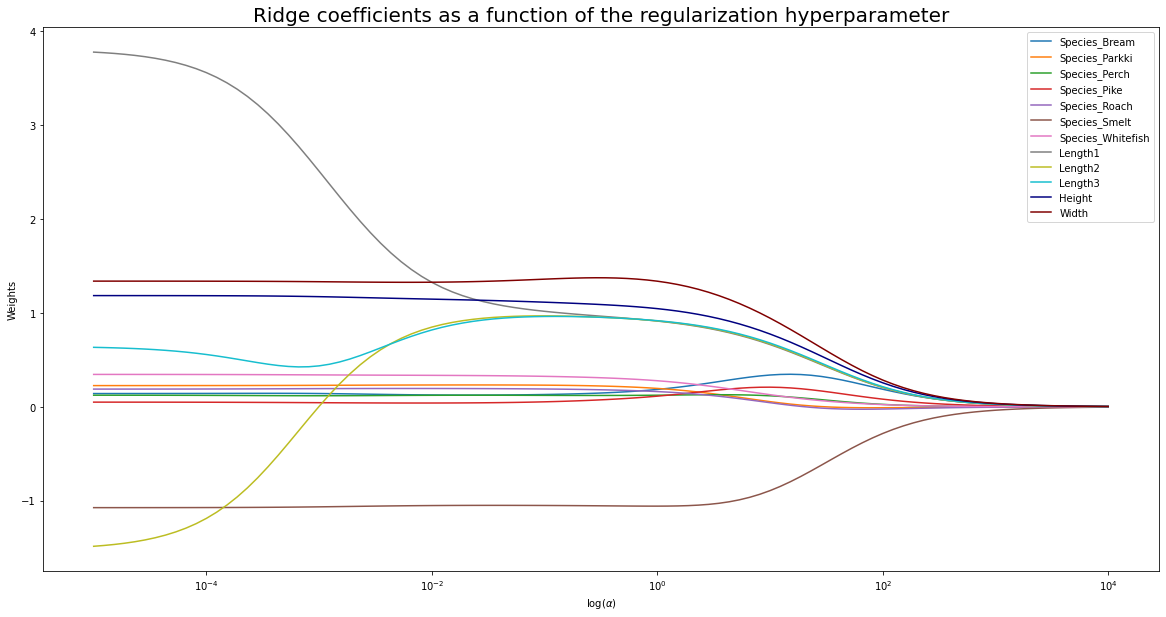

In [21]:
#Choose a range of interest for the penalty hyperparameter, where all coefficients are zero in one end and all coefficients are non-zero in the other end.
alphas = np.logspace(-5, 4, 100)
method = lm.Ridge

# Get mean/std and coeffs for Ridge regression method
ridge_means, ridge_stds, coeffs = reg_select(method, X_train, y_train, alphas)

# Plot them
plot_regularizer(alphas, ridge_means, ridge_stds, coeffs, list(X_train.columns), method="Ridge")

alpha_best = alphas[np.argmax(ridge_means)]
best_mean = ridge_means[np.argmax(ridge_means)]
best_std = ridge_stds[np.argmax(ridge_means)]
print("Best alpha is ", alpha_best)
print("Cross-Validation R2-score is {:0.3f} +/- {:0.3f}".format(best_mean, best_std))

ridge_cv_mean = best_mean
ridge_cv_std = best_std

# Fit model with the optimal regularizer
Ridge_model = lm.Ridge(alpha=alpha_best).fit(X_train, y_train)

## Lasso

Regularizes the models by limiting the coefficients' size according to: $\min_\beta \frac{1}{2n_{samples}}||X^T\beta - y||_2^2 + \alpha ||\beta||_1$

The same procedure as done when finding the best hyperparameters for Ridge regression is followed below.
There is a similar interaction between the coefficents for $\textit{Length1}$ and $\textit{Length2}$ as for Ridge regression, but their development as the regularization increases is considerably less smooth than for Ridge.

Processing alpha 10.00 of 10.00 
Best alpha is  0.002310129700083158
Score is 0.959 +/- 0.030


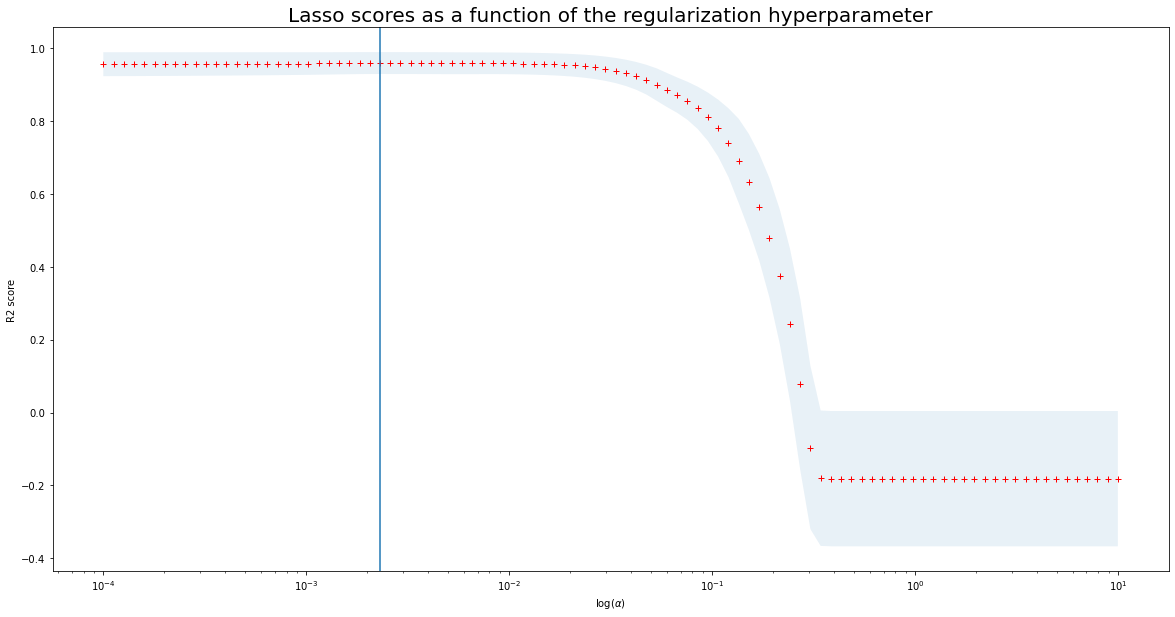

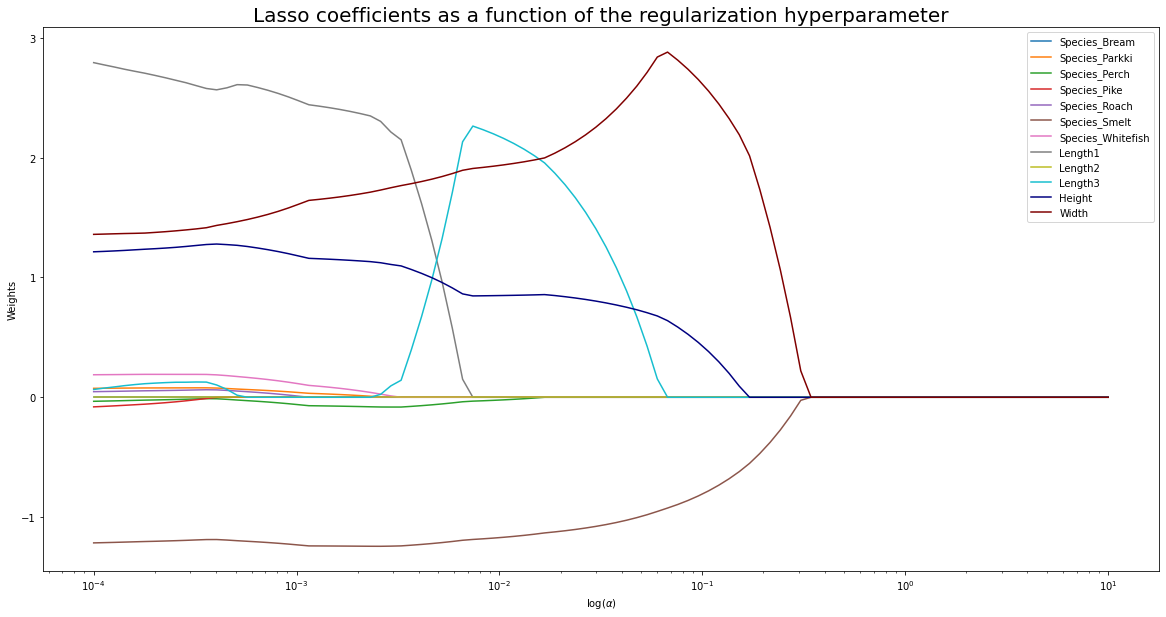

In [22]:
#Choose a range of interest for the penalty hyperparameter, where all coefficients are zero in one end and all coefficients are not zero in the other end.
alphas = np.logspace(-4, 1, 100)
method = lm.Lasso

# Get mean/std and coeffs for Lasso regression method
lasso_means, lasso_stds, lasso_coeffs = reg_select(method, X_train, y_train, alphas)

# Plot them
plot_regularizer(alphas, lasso_means, lasso_stds, lasso_coeffs, list(X_train.columns), method="Lasso")


# alpha max når alle coeffs blir 0
alpha_best = alphas[np.argmax(lasso_means)]
best_mean = lasso_means[np.argmax(lasso_means)]
best_std = lasso_stds[np.argmax(lasso_means)]
print("Best alpha is ", alpha_best)
print("Score is {:0.3f} +/- {:0.3f}".format(best_mean, best_std))

lasso_cv_mean = best_mean
lasso_cv_std = best_std

# Fit model with the optimal regularizer
Lasso_model = lm.Lasso(alpha=alpha_best).fit(X_train,y_train)


## Sparse Group Lasso


The Sparse Group Lasso estimator is defined by:

$\argmin_{\beta_g \in \mathbb{R}^{d_g}} || \sum_{g\in \mathcal{G}} [\mathbf{X}_g \beta_g]-\mathbf{y}||_2^2 + \lambda_1 ||\beta||_1 + \lambda_2 \sum_{g\in\mathcal{G}}\sqrt{d_g}||\beta_g||_2$ [4]

The sparse group lasso regularizer is a combination of standard lasso and group lasso regularization. This also means that there are two hyperparameters to tune.

The first hyperparameter is group regularization, denoted in code by "group_reg" and the second hyperparameter is $L_1$ regularization, denoted by "l1_reg". Therefore, we need 2D cross-validation to determine the best set of hyperparameters. 

Since we have seven categorical variables that show the species of the fish, we group these variables together. The other covariates are not grouped, which means that they are only regularized with normal lasso.

We plot the mean cross-validated R2 score on a surface to determine the best set of hyperparameters, indicated by a red dot.

In [12]:

# 2D Cross-Validation for Group Lasso
l1_reg_space = np.logspace(-4, 1, 25)
group_reg_space = np.logspace(-4, 1, 25)
gl_scores = np.empty((25,25))
gl_std = np.empty((25,25))

groups = [1,1,1,1,1,1,1,-1,-1,-1,-1,-1]  # With one-hot encoding, grouping species

for i, l1_reg in enumerate(l1_reg_space):
    for j, group_reg in enumerate(group_reg_space):
        print("\rProcessing [{},{}]:".format(i,j), end="", flush=True)
        gl = GroupLasso(
            groups=groups,
            group_reg=group_reg,
            l1_reg=l1_reg,
            frobenius_lipschitz=True,
            scale_reg="inverse_group_size",
            subsampling_scheme=1,
            supress_warning=True,
            n_iter=10000,
            tol=1e-3,
        )
        #scores[i,j] = cross_validate(method, X_no_species_train, y_no_species_train, cv=10, scoring="r2")
        temp_scores = cross_validate(gl, X_train, y_train, cv=10, scoring="r2")["test_score"]
        gl_scores[i,j] = temp_scores.mean()
        gl_std[i,j] = temp_scores.std()




Processing [24,24]:

In [13]:
# 3D plotting with log-scaled axes and interactive figures

pio.renderers.default = 'notebook'

# Define axes and surface
_x = np.logspace(-4,1,25)
_y = np.logspace(-4,1,25)
_z = gl_scores


# Stolen from subsequent code cell to mark best hyperparam choice in plots
max_index = np.unravel_index(gl_scores.argmax(), gl_scores.shape)
best_mean = gl_scores[max_index]
best_std = gl_std[max_index]
best_l1_lambda = l1_reg_space[max_index[0]]
best_group_lambda = group_reg_space[max_index[1]]

# Create container for 2 subplots
fig = go.Figure(data=[go.Surface(z=_z,x=_x, y=_y)])

# Mark best hyperparameter choice as a red dot
fig.add_trace(
    go.Scatter3d(
        z=np.array(gl_scores[max_index]), 
        x=np.array(l1_reg_space[max_index[0]]), 
        y=np.array(group_reg_space[max_index[1]])
    )
)

# Set first plot to have log scaling
fig.update_layout(#title="Hyperparameter search for Group Lasso using Cross-Validation", 
                  scene=dict(
                    xaxis_title="l1_reg",
                    xaxis_type="log",
                    yaxis_title="group_reg",
                    yaxis_type="log",
                    zaxis_title="mean CV score"
                  ))


fig.show()

We now select the regularization hyperparameters that gave the best mean CV-score and fit our model.

In [14]:
max_index = np.unravel_index(gl_scores.argmax(), gl_scores.shape)
best_mean = gl_scores[max_index]
best_std = gl_std[max_index]
best_l1_lambda = l1_reg_space[max_index[0]]
best_group_lambda = group_reg_space[max_index[1]]


print("Best l1 lambda is ", best_l1_lambda, ", best group lambda is ", best_group_lambda)
print("Score is {:0.3f} +/- {:0.3f}".format(best_mean, best_std))

# Fit best group lasso model:
gl = GroupLasso(
            groups=groups,
            group_reg=best_group_lambda,
            l1_reg=best_l1_lambda,
            frobenius_lipschitz=True,
            scale_reg="inverse_group_size",
            subsampling_scheme=1,
            supress_warning=True,
            n_iter=10000,
            tol=1e-3,
        )
gl_model = gl.fit(X_train, y_train)

Best l1 lambda is  0.0011006941712522103 , best group lambda is  0.0002610157215682536
Score is 0.960 +/- 0.030


# Results

In this section we compare the methods' CV performance and apply the best performing method on the test data. Finally, we compare the models' coefficient estimates.

### Comparing cross-validation results of the models used in this paper

| Model | Mean CV R2-score | Standard deviation CV R2 score |
| --- | --- | --- |
| OLS | 0.954 | 0.034 |
| **Ridge** | **0.960** | **0.030** |
| Lasso | 0.959 | 0.030 |
| **Sparse group lasso** | **0.960** | **0.030** |

As can been seen from the table above, the model that got the best cross-validation results from the experiments done in this report is Ridge regression. Therefore, we now test this model on the test data. 

## Applying the methods to the test data

In [15]:
# Train a new model with best method and its best regularizer parameter
model = lm.Ridge(alpha=alpha_best).fit(X_train,y_train)

print("Test set R2-score is", model.score(X_test, y_test))

# Predict some fish weights
pred = model.predict(X=X_test)

# Print prediction vs. true values
for i in np.random.randint(0,len(X_test), size=10):
    print("Fish #", i+1, "log-weight:", y_test.iloc[i], "\t model prediction:", pred[i])

Test set R2-score is 0.9784376474312109
Fish # 24 log-weight: 6.1092475827643655 	 model prediction: 6.016453085114033
Fish # 22 log-weight: 6.882437470997847 	 model prediction: 7.256473669652644
Fish # 32 log-weight: 5.598421958998375 	 model prediction: 5.480019974008931
Fish # 14 log-weight: 4.007333185232471 	 model prediction: 4.311412827858773
Fish # 3 log-weight: 6.551080335043404 	 model prediction: 6.416702879791066
Fish # 8 log-weight: 6.856461984594587 	 model prediction: 6.9867683342373805
Fish # 16 log-weight: 5.236441962829949 	 model prediction: 5.061171228669187
Fish # 22 log-weight: 6.882437470997847 	 model prediction: 7.256473669652644
Fish # 18 log-weight: 5.19295685089021 	 model prediction: 4.9710220642792144
Fish # 6 log-weight: 7.003065458786462 	 model prediction: 6.9256574189501


Typically, one would expect a worse test set performance compared to the training CV score. In our case, the R2-score on the test set is actually better than the mean from the cross-validation. The score on the test set is, however, still within one standard deviation from the mean score of the cross-validation performance. While this is uncommon, it is not unreasonable considering the small sample size and accurate model.

## Comparing model coefficients

To further compare the different models, we will now plot the coefficients of the different models used in this report. These coefficients correspond to the best performing model for each method in the cross-validation. 


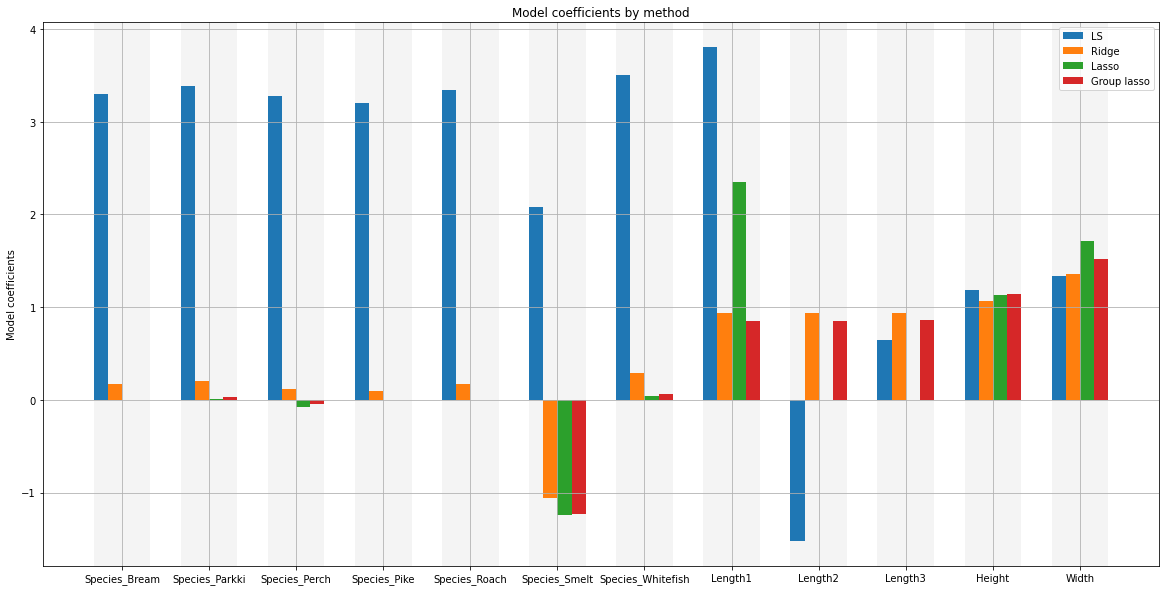

In [19]:
# Relate coefficients to covariates
labels = list(X_train.columns)

x = np.arange(12)  # the label locations
width = 0.65  # the width of the bars

fig, ax = plt.subplots(figsize=(20,10))

for i in x: # Gray background
    ax.axvspan(i-width/2, i+width/2, facecolor='0.2', alpha=0.05)

rects1 = ax.bar(x - 3*width/8, LS_model.coef_, width/4, label='LS')
rects2 = ax.bar(x - width/8, Ridge_model.coef_, width/4, label='Ridge')
rects3 = ax.bar(x+width/8, Lasso_model.coef_, width/4, label='Lasso')
rects4 = ax.bar(x + 3*width/8, np.squeeze(gl_model.coef_), width/4, label='Group lasso')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Model coefficients')
ax.set_title('Model coefficients by method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(bottom=-1000, top=1000)
ax.legend()

#ax.set_yscale('symlog')
#fig.tight_layout()
plt.grid()
plt.show()


## Discussing which method is best for the dataset

Note that only lasso picks a single one of the highly correlated covariates (the lengths) while forcing the others to zero. Instead, both ridge and sparse group lasso set the coefficients of these three lengths to approximately the same value. 

In [17]:
print(Lasso_model.coef_)

[-0.          0.00864809 -0.07958473  0.         -0.         -1.24399813
  0.04050564  2.34885466  0.          0.          1.1323412   1.71248758]


Consider that Lasso achieves only marginally worse predictive power than Ridge and Group Lasso. However, Lasso also ignores 5 of the 12 covariates, thus predicting with a significantly simpler model than the other methods. If we had applied the one standard error rule for hyperparameter selection for Lasso, then more of the covariates would have been ignored in the model.

# References

[1] Hastie, T., Hastie, T., Tibshirani, R., & Friedman, J. H. (2001). The elements of statistical learning: Data mining, inference, and prediction. New York: Springer.

[2] Dataset: https://www.kaggle.com/aungpyaeap/fish-market

[3] Normality testing: https://www.math.ntnu.no/emner/IST100x/ISTx1003/Regresjon.html#Simulert_eksempel_(forts)31

[4] Moe, Y. M. (2019), Group-lasso docs https://group-lasso.readthedocs.io/